In [1]:
import warnings 
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta # for dates 
from scipy.optimize import minimize # for function minimization

# for statistics
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm 
import scipy.stats as scs 

from itertools import product 
from tqdm import tqdm_notebook 

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Data importing and visualisation 

In [14]:
ads  = pd.read_csv('ads.csv',index_col=['Time'],parse_dates=['Time'])
currency = pd.read_csv('currency.csv',index_col=['Time'], parse_dates=['Time'])

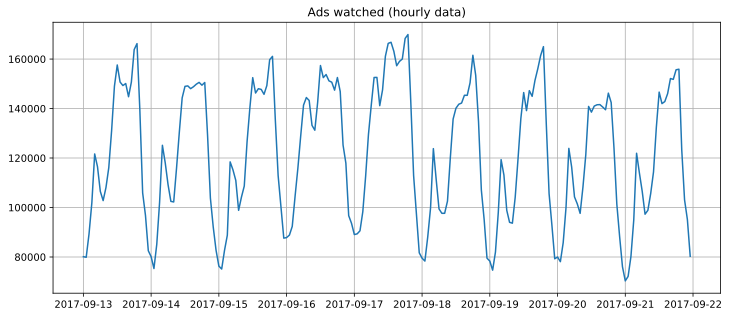

In [15]:
plt.figure(figsize=(12,5))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

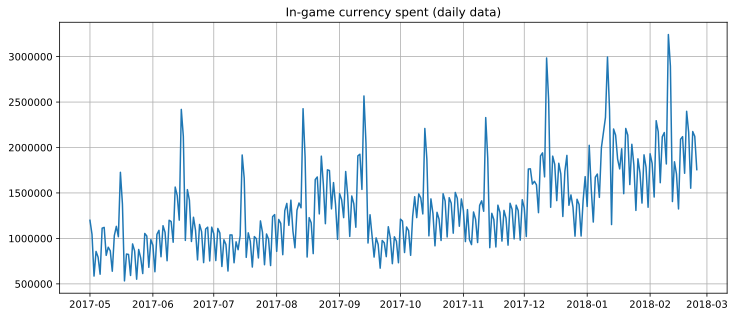

In [16]:
plt.figure(figsize=(12,5))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### Forecast Quality Metrics: <br/> 

The most common used metrics:

- R squared: coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), 
$(-\infty, 1]$ <br/>

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

- Mean Absolute Error: this is an interpretable metric because it has the same unit of measurment as the initial series,$[0, +\infty)$ 

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

- Median Absolute Error: again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

- Mean Squared Error: the most commonly used metric that gives a higher penalty to large errors and vice versa,$[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

- Mean Squared Logarithmic Error: practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends,$[0, +\infty)$ 

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

- Mean Absolute Percentage Error:this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management,$[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$


Metrics Importing 

In [17]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

### Moving Average
We will assume that future value of our variable depends on the average of its k previous values.It is called moving average:

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$


In [18]:
def moving_average(series,n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

# Predict based on last day (past 24 hours)
moving_average(ads,24)
print('Prediction: '+str(moving_average(ads,24))+' views')

Prediction: 116805.0 views


Unfortunately, Moving Average allows us to make a single-step prediction because for the next value, we need the previous values to be observed which is impossible as we are predicting them. But it has another useful implementation - smoothing in order to identify trends and patterns in Time Series.

In [19]:
def plot_moving_average(series,window,plot_intervals=False,scale = 1.96,plot_anomalies=False):

    """
        series - dataframe with a timeseries 
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
        
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(12,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label='Rolling Mean Trend')
    
    # Plot Confidence Intervals for smoothed Time Series
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale*deviation)
        upper_bound = rolling_mean + (mae + scale*deviation)
        plt.plot(upper_bound,'r--',label='Upper Bound/Lower Bound')
        plt.plot(lower_bound,'r--')
        
        # Looking for outliers in intervals
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index,columns=series.columns)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies,'ro',markersize=10)
        
    plt.plot(series[window:],label = "Actula Time Series")
    plt.legend(loc='upper left')
    plt.grid(True)

Smooth by the previous 4 hours

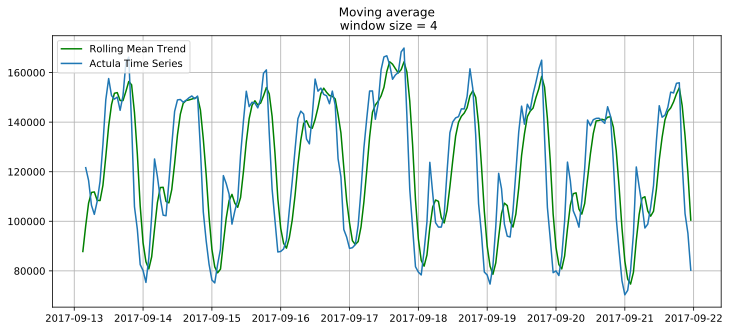

In [20]:
plot_moving_average(ads,4)

Smooth by the previous 12 hours

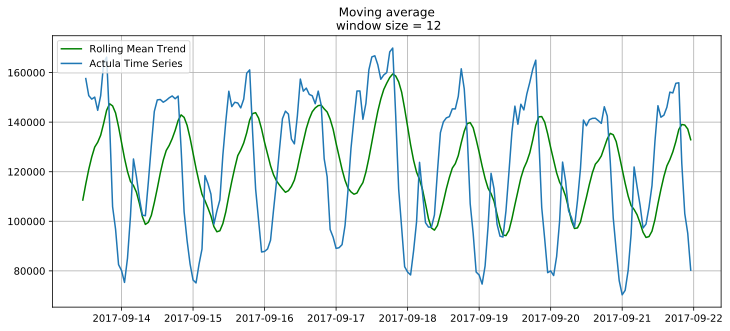

In [21]:
plot_moving_average(ads,12)

Smooth by the previous 24 hours

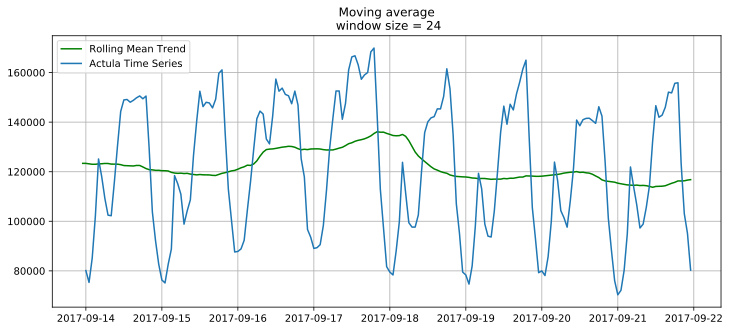

In [22]:
plot_moving_average(ads,24)

With the help of smoothing we can clearly see the dynamics of ads watched <br/>
At the weekends the values are higher rather than on weekdays

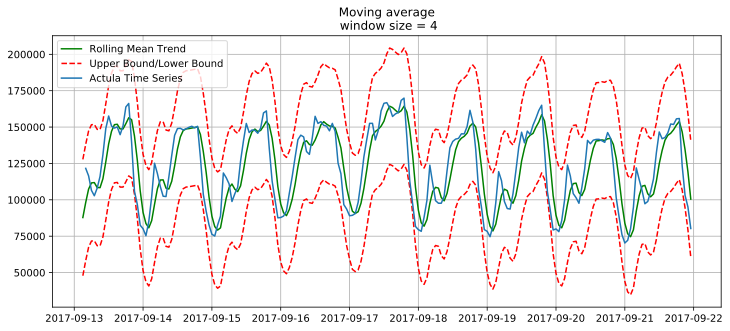

In [23]:
plot_moving_average(ads,4,plot_intervals=True)

To detect anomalies we intentionally add some outliers in the dataset

In [24]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20]*0.2

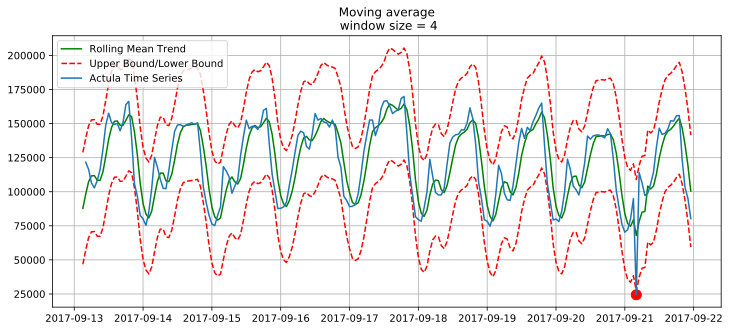

In [25]:
plot_moving_average(ads_anomaly,4,plot_intervals=True,plot_anomalies=True)

For the second Time Series

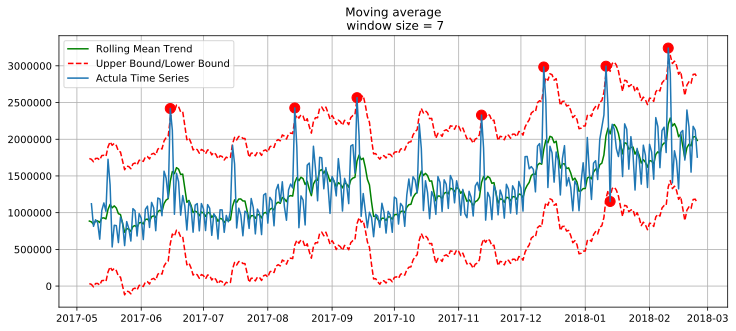

In [26]:
# Weekly Smoothing
plot_moving_average(currency,7,plot_intervals=True,plot_anomalies=True)

Can clearly see that it cannot capture the monthly seasonality.To avoid this we need to build more complex models

### Weighted Average
Weighted average is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$


In [27]:
def weighted_average(series,weights):
    result = 0.0
    weights.reverse()
    for i in range(len(weights)):
        result += series.iloc[-i-1]*weights[i]
    return float(result)

weighted_average(ads,[0.6,0.3,0.1])

98423.0

### Exponential Smoothing 

If we start weighting all available observations while exponentially decreasing the weights as we move futher back in time

$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}$

The  $α$  weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller  $α$  is, the more influence the previous observations have and the smoother the series is.

In [28]:
def exponential_smoothing(series,alpha):
    """
        series - Time Series
        alpha - float [0.0, 1.0] smoothing parameter
    
    """
    result = [series[0]]
    
    for i in range(1,len(series)):
        result.append(alpha*series[i]+(1-alpha)*result[i-1])
    return result

In [29]:
def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas 
        
        series - Time Series
        alphas - list of floats, smoothing parameters
    
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(12,5))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series,alpha),label = 'Alpha{}'.format(alpha))
            
        plt.plot(series.values, 'c',label = 'Actual Time Series')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True)

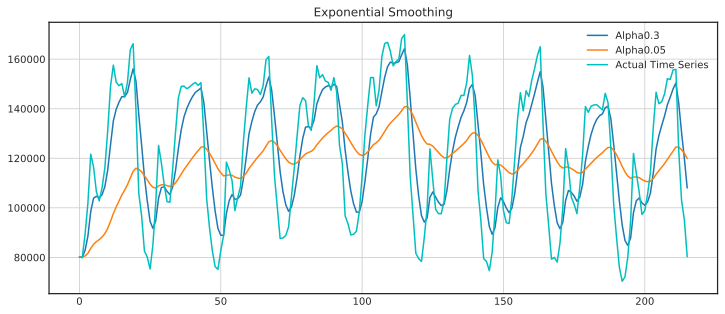

In [30]:
plot_exponential_smoothing(ads.Ads,[0.3, 0.05])

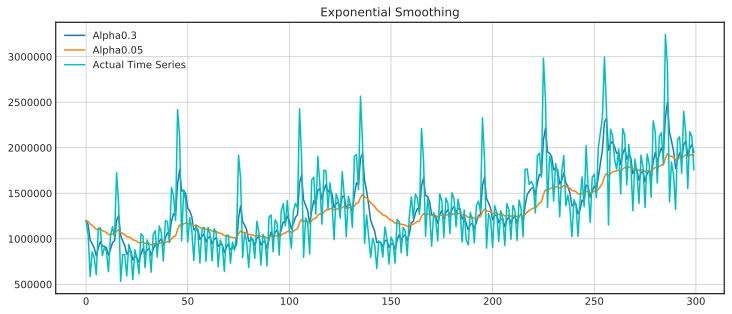

In [31]:
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT, [0.3,0.05])

### Double Exponential Smoothing 
We can extend exponential smoothing so that we can predict two future points
We obtain two components:
* Level $\ell$
* Trend $b$

Now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:
$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$
$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$
$$\hat{y}_{x+1} = \ell_x + b_x$$

The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend.
the $\beta$ coefficient is a weight for exponential smoothing.

The final prediction is the sum of the model values of the intercept and trend.

In [32]:
def double_exponential_smoothing(series,alpha,beta):
    """
        series - Time Series
        alpha -  float [0.0, 1.0] - smoothing parameter for level
        beta  -  float [0.0, 1.0] - smoothing parameter for trend
        
    """
    # first value is same as series
    result = [series[0]]
    for i in range(1,len(series)+1):
        if i == 1:
            # determine trend and level of TS
            level,trend = series[0], series[1] - series[0]
        if i >= len(series): # forecasting 
            value = result[-1]
        else:
            value = series[i]
        last_level, level = level,alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level - last_level) + (1 - beta)*trend
        result.append(level+trend)
    return result

def plot_double_exponential_smoothing(series,alphas,betas):
    """
        series - dataset with timestamps
        alphas - list of floats, smoothing parameter for level
        betas - list of floats, smoothing parameter for trend
        
    """
    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(12,5))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series,alpha,beta),label="Alpha {}, beta {}".format(alpha,beta))
                
        plt.plot(series.values, label = 'Actual Time Series')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

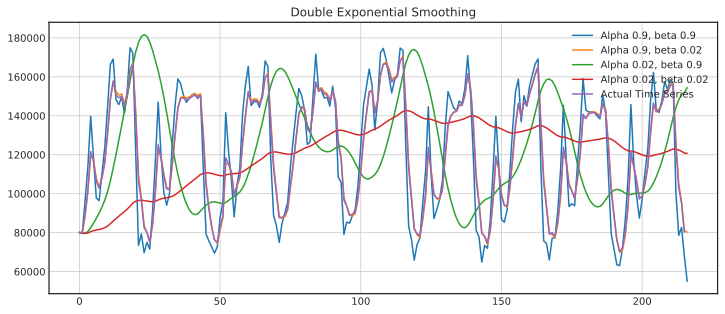

In [33]:
plot_double_exponential_smoothing(ads.Ads, alphas=[0.9,0.02], betas=[0.9,0.02])

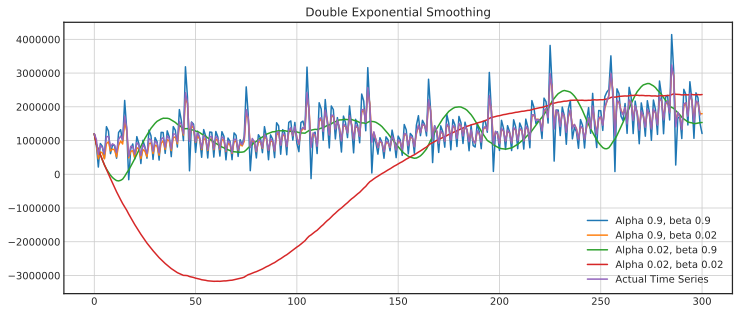

In [34]:
plot_double_exponential_smoothing(currency.GEMS_GEMS_SPENT,alphas=[0.9,0.02], betas=[0.9,0.02] )

Now we have to tune two parameters $\alpha$ and $\beta$ 
* $\alpha$ is responsible for the series smoothing around the trend
* $\beta$ is resonsible for the smoothing of the trend itself

The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be.

### Triple Exponential Smoothing (Holt-Winters Model)

The idea here is to add seasonality and hence we need to use this method if our Time Serie has a seasonality.
Seasonality is repeated variations around level and trend and will be specified by the length of the season.

For each observation in the season, there is a separate component ( for example, if the season is 7 days we will have 7 seasonal components, one for each day of the week)

Equations System:
$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$
$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$
$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$
$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary  $m$  future steps ahead, which is very encouraging.

Brutlag method to produce confidence intervals:
$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$
$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$
$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

$T$ is the length of the season<br/>
$d$ is the predicted deviation

In [38]:
class HoltWinters:
    """
        Holt-Winters model with the anomalies detection using Brutlag method
    
        # series - initial time series
        # slen - length of a season
        # alpha, beta, gamma - Holt-Winters model coefficients
        # n_preds - predictions horizon
        # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    def __init__(self,series,slen,alpha,beta,gamma,n_preds,scaling_factor=1.96):
       
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i])/self.slen
        return sum/self.slen
        
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # Season Averages Calculation
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
            # Initial Values Calculation
            for i in range(self.slen):
                sum_of_vals_over_avg = 0.0
                for j in range(n_seasons):
                    sum_of_vals_over_avg += self.series[self.slen*j+i] - season_averages[j]
                seasonals[i] = sum_of_vals_over_avg/n_seasons
            return seasonals
    
    def triple_exponential_smoothing(self):
        
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
            
            if i >= len(self.series): # Predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [42]:
class HoltWinters:
    
    """
        Holt-Winters model with the anomalies detection using Brutlag method
    
        # series - initial time series
        # slen - length of a season
        # alpha, beta, gamma - Holt-Winters model coefficients
        # n_preds - predictions horizon
        # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # Season Averages Calculation
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # Initial Values Calculation
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # Predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                 # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Time Series Cross Validation

In order to estimate model parameters aoutomatically we will use unusual cross validation due to time dependencies in time series

We cannot randomly mix values in a fold. With randomization, all time dependencies between observations will be lost

Thus,we will use cross validation on a rolling window

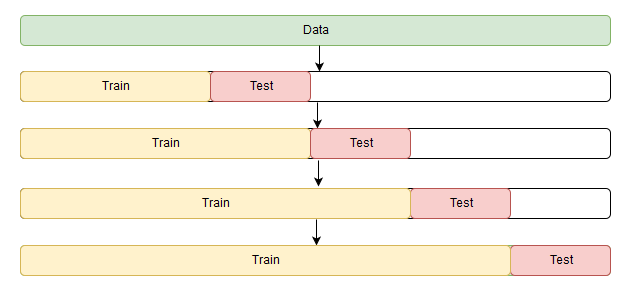

In [43]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_CV_score(params,series,loss_func = mean_squared_error,slen=24):
    """
        Will be returning error on CV
        
        params - vector of parameters for optimization
        sereis - Time Series
        slen - season length
    
    """
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # Set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Itereate over folds,train model on each, forecast and calculate an error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, alpha=alpha, beta=beta, gamma=gamma,n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_func(predictions,actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

There is a constraint in Holt-Winters model on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [44]:
%%time
data = ads.Ads[:-20] # Leave some data for testing 

# Initializing model parameters alpha,beta,gamma
x = [0,0,0]

# Minimizing the loss function
opt = minimize(time_series_CV_score,x0 = x,args=(data, mean_squared_log_error), method="TNC", bounds = ((0,1),(0,1),(0,1)))

# Take optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# Train the model with the best parameters and forecast for the next 50 hours
model = HoltWinters(data,slen=24,
                   alpha=alpha_final,
                   beta=beta_final,
                   gamma=gamma_final,
                   n_preds= 50,scaling_factor=3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
Wall time: 1.76 s


Plots Rendering

In [46]:
def plot_HoltWinters(series,plot_intervals=False,plot_anomalies=False):
    """
        series - Time Series
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    
    """
    plt.figure(figsize=(12,5))
    plt.plot(model.result,label = 'Model')
    plt.plot(series.values,label = 'Actual')
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
        
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

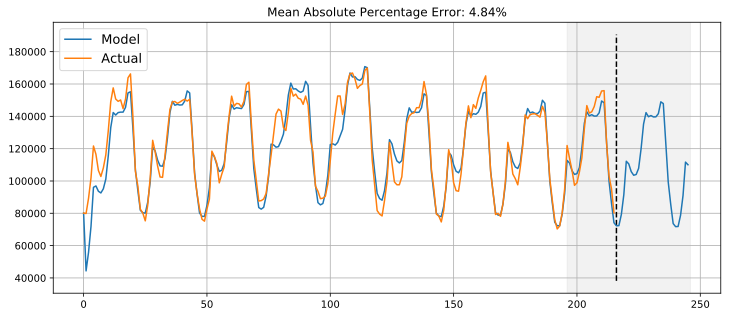

In [47]:
plot_HoltWinters(ads.Ads)

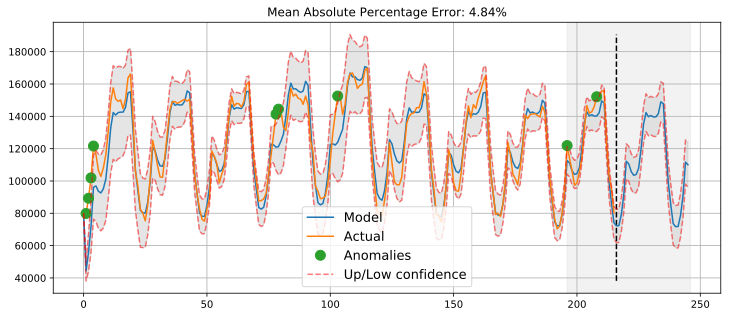

In [48]:
plot_HoltWinters(ads.Ads,plot_intervals=True,plot_anomalies=True)

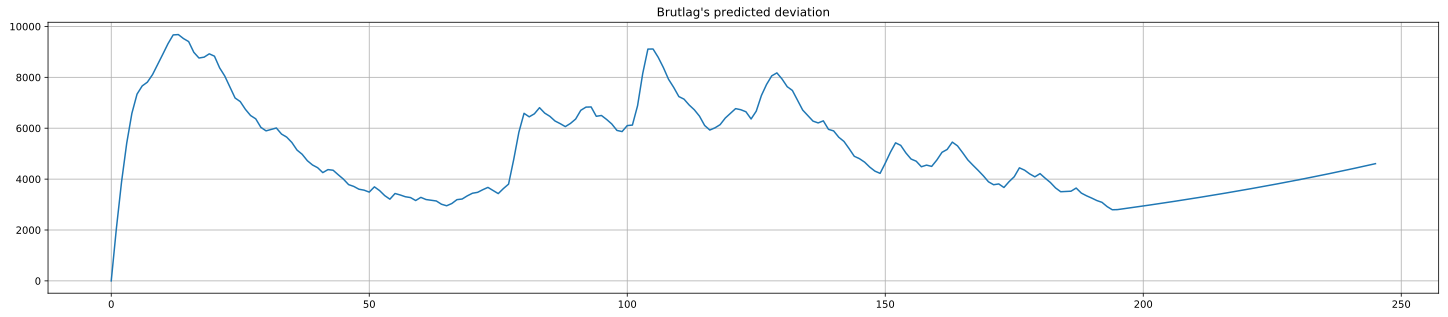

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Apply the same algorithm for the second series

In [50]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50]
slen = 30 # 30-day seasonality

x = [0,0,0]

opt = minimize(time_series_CV_score, x0=x,
              args=(data,mean_absolute_percentage_error, slen),
              method='TNC', bounds=((0,1), (0,1), (0,1)) )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
Wall time: 2.36 s


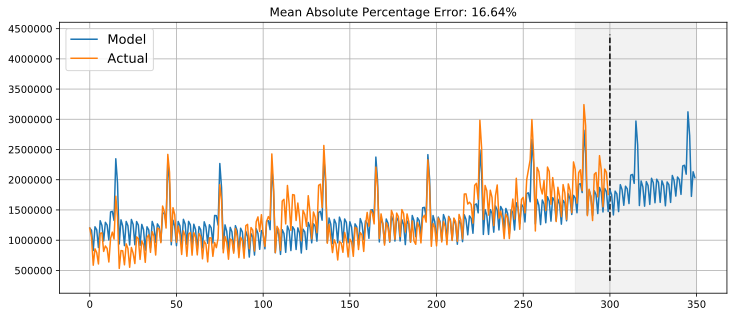

In [52]:
plot_HoltWinters(currency.GEMS_GEMS_SPENT)

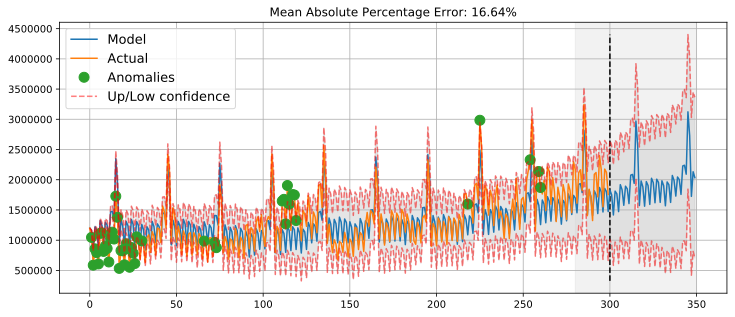

In [53]:
plot_HoltWinters(currency.GEMS_GEMS_SPENT,plot_intervals=True,plot_anomalies=True)

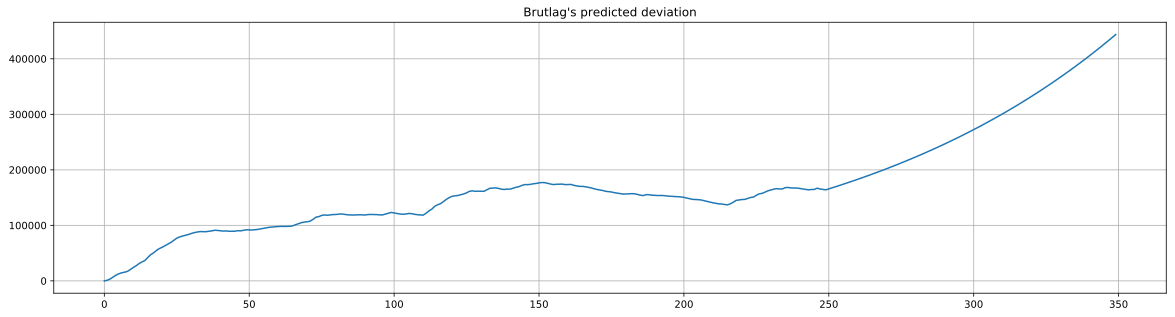

In [54]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### Time Series Stationarity 

Before we start modeling, we should mention such an important property of time series: stationarity.

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called homoscedasticity)The covariance function does not depend on time; it should only depend on the distance between observations.

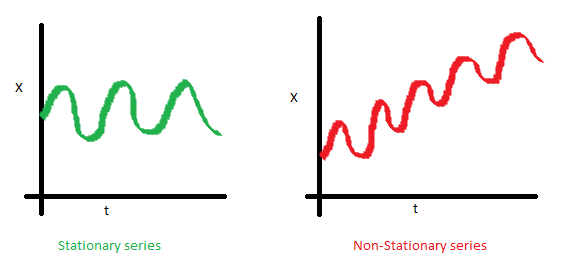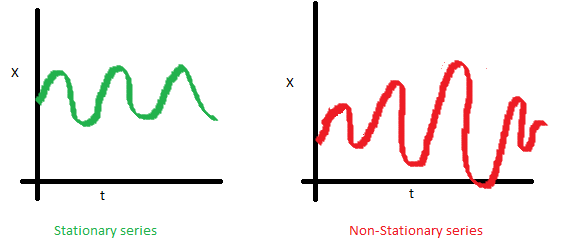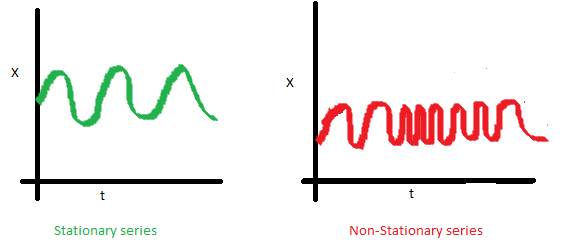

It is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

### SARIMA Building and Getting Rid of Non-Stationarity 

In [55]:
def tsplot(y, lags=None, figsize=(12, 5), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

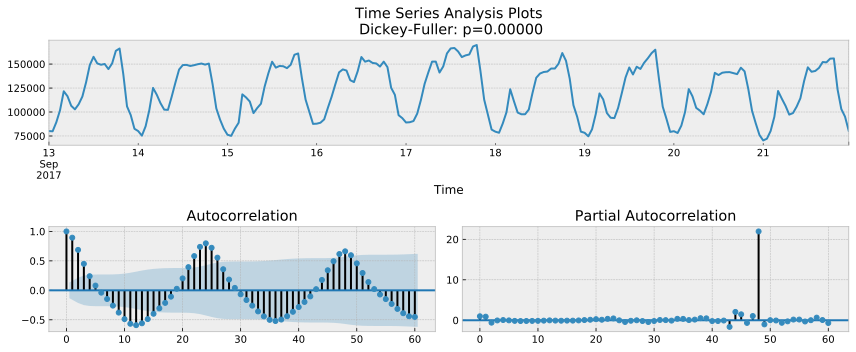

In [56]:
tsplot(ads.Ads, lags=60)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

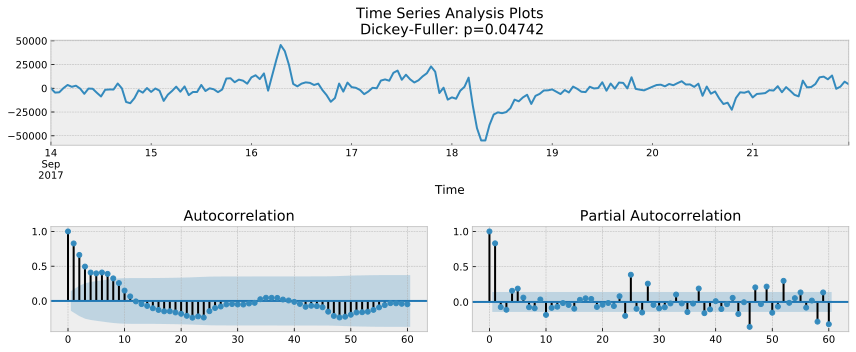

In [59]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

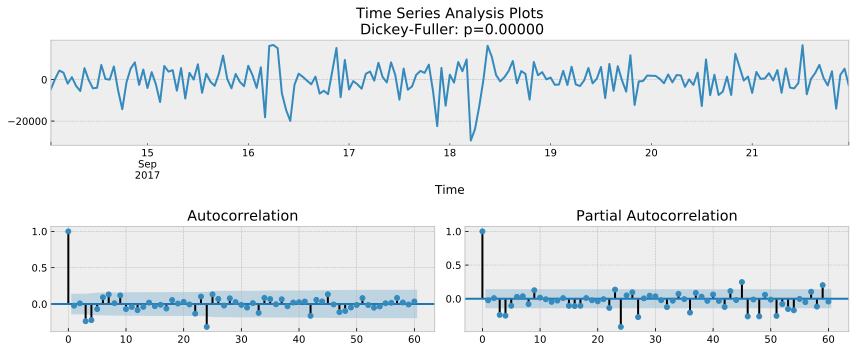

In [60]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

SARIMA Parameters

$SARIMA(p, d, q)(P, D, Q, s)$ (Seasonal Autoregression Moving Average model):

$AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.

$MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before.

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

$I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

$S(s)$ - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters: $(P, D, Q)$

$P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

$Q$ - similar logic using the ACF plot instead.

$D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

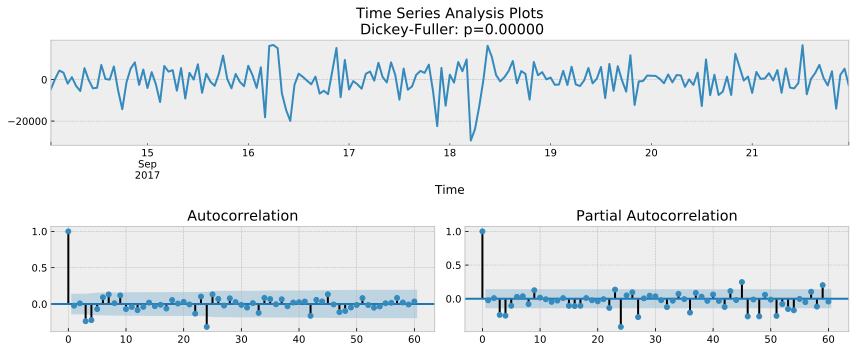

In [61]:
tsplot(ads_diff[24+1:], lags=60)

* $p$ is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant.
* $d$ equals 1 because we had first differences
* $q$ should be somewhere around 4 as well as seen on the ACF
* $P$ might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
* $D$ again equals 1 because we performed seasonal differentiation
* $Q$ is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

Let's test various models and see which one is better

In [62]:
# Initial values and bounds for them 
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# List with all possible parameters combination 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [64]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [65]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_m


Wall time: 2min 10s


In [66]:
result_table.head()

,parameters,aic
0,"(2, 3, 0, 1)",3888.642174
1,"(2, 3, 1, 1)",3888.642174
2,"(3, 2, 0, 1)",3888.763568
3,"(3, 2, 1, 1)",3888.763568
4,"(4, 2, 1, 1)",3890.279740


In [67]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

c:\python 3.6.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 24)   Log Likelihood               -1941.585
Date:                            Sun, 12 Apr 2020   AIC                           3897.171
Time:                                    22:36:00   BIC                           3919.937
Sample:                                09-13-2017   HQIC                          3906.392
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7653      0.223      3.436      0.001       0.329       1.202
ar.L2         -0.5354      0.263   

Let's inspect the residuals of the model.

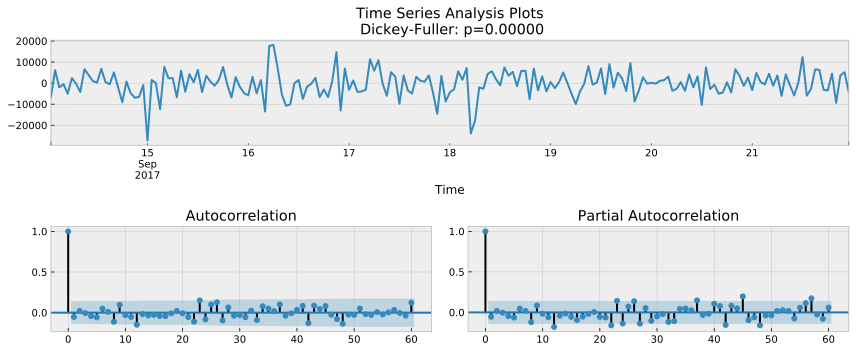

In [68]:
tsplot(best_model.resid[24+1:], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

In [70]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(12, 5))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

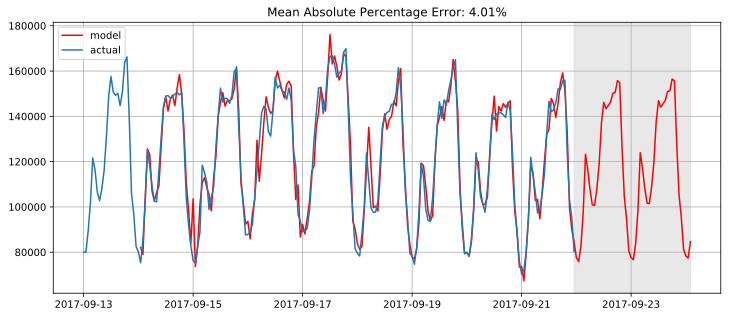

In [71]:
plotSARIMA(ads, best_model, 50)

### Linear Regression and Features Extraction

The model needs features, and all we have is a 1-dimentional time series. What features can we exctract?

* Lags of time series
* Window statistics:
* Max/min value of series in a window
* Average/median value in a window
* Window variance

* Date and time features:
   * Minute of an hour, hour of a day, day of the week, and so on
   * Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
* Target encoding
* Forecasts from other models (note that we can lose the speed of prediction this way)

### Time Sereis Lags

Shifting the series $n$ steps back, we get a feature column where the current value of time series is aligned with its value at time $t-n$. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [99]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [100]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [101]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [103]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [104]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [105]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(10, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

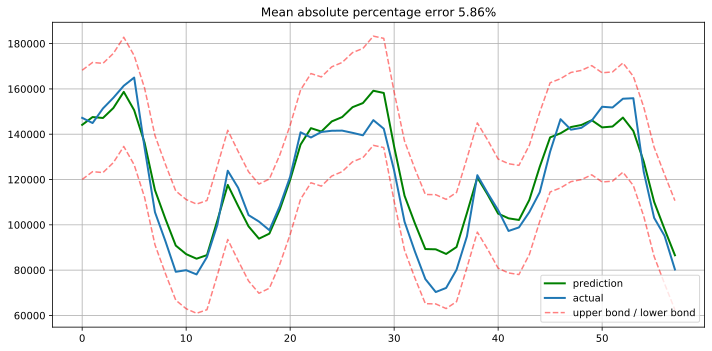

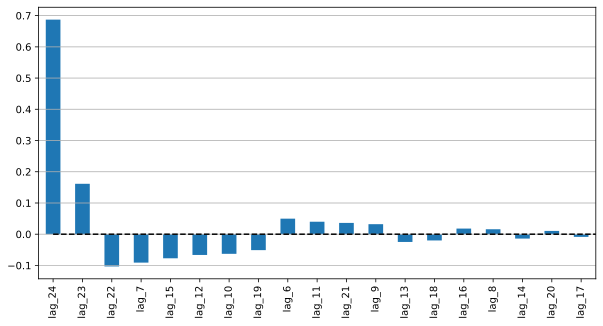

In [113]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us predictions that are not that far off from SARIMA in terms of quality. There are many unnecessary features, so we'll do feature selection in a little while. For now, let's continue engineering!

We'll add hour, day of week, and a boolean for is_weekend. To do so, we need to transform the current dataframe index into the datetime format and extract hour and weekday.

In [114]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


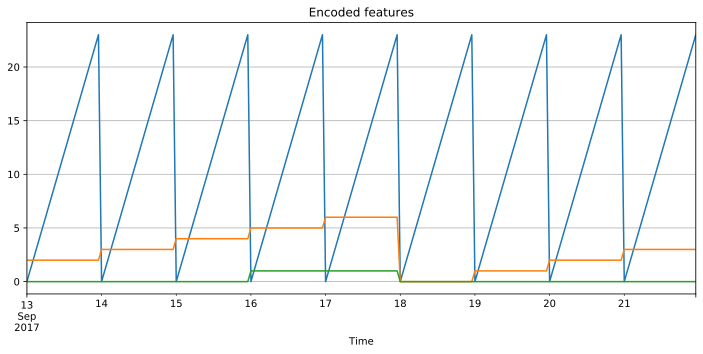

In [115]:
plt.figure(figsize=(12, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

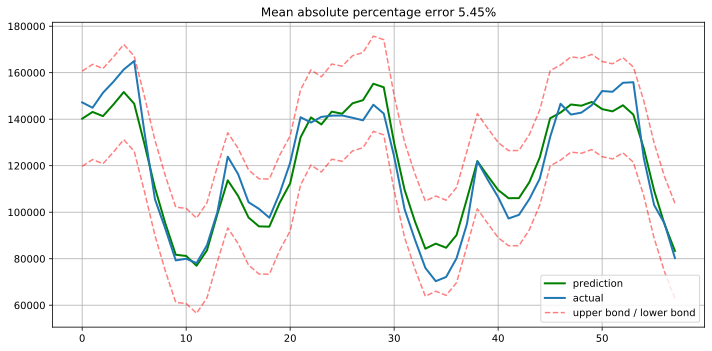

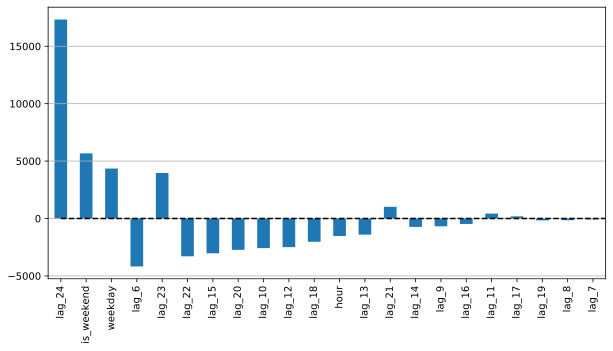

In [117]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The test error goes down a little bit. Judging by the coefficients plot, we can say that weekday and is_weekend are useful features

### Target Encoding 

I'd like to add another variant for encoding categorical variables: encoding by mean value. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [118]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

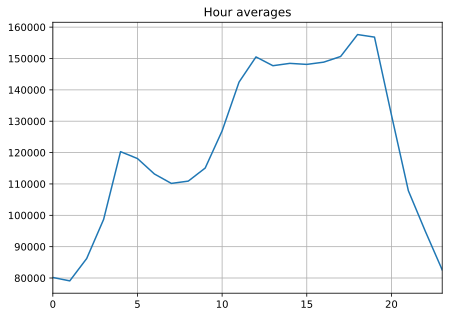

In [119]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [120]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

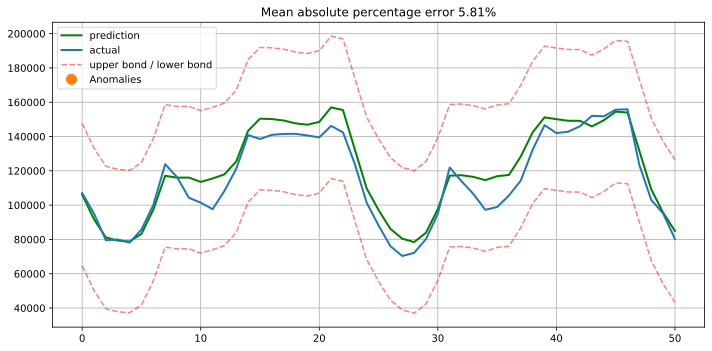

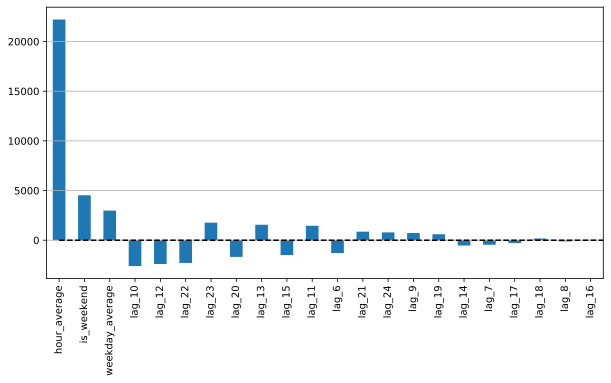

In [121]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We see some overfitting! Hour_average was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case.

In [122]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regularization and feature selection

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function.

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low.

As a result of this $L2$ regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called $L1$.

First, let's make sure that we have features to drop and that the data has highly correlated features.

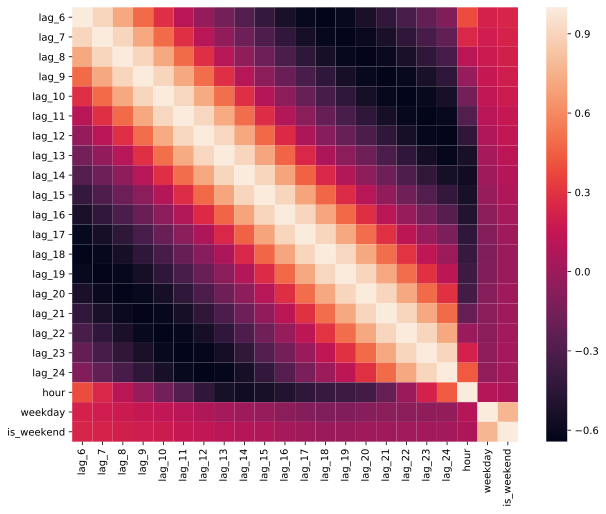

In [123]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

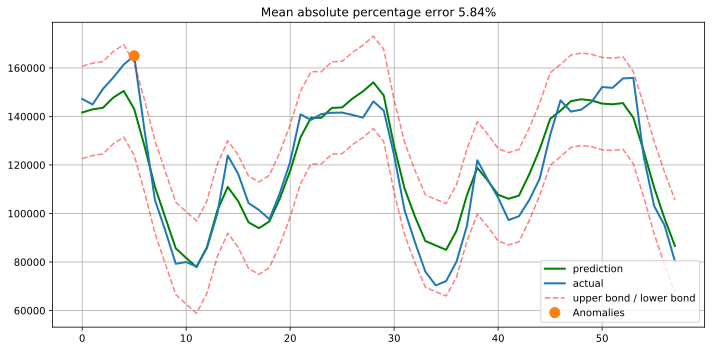

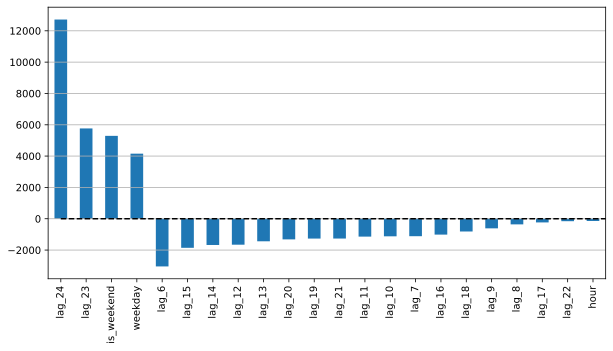

In [124]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

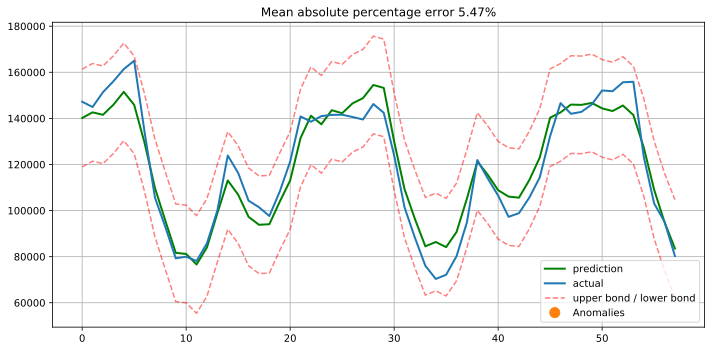

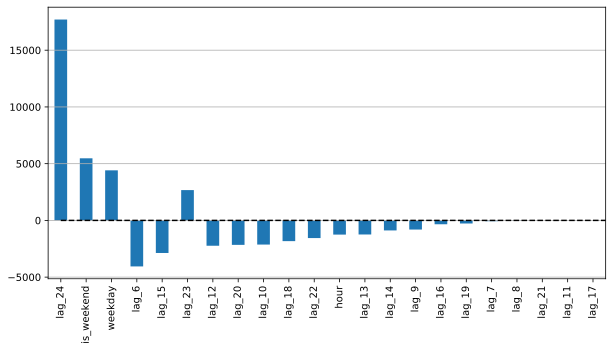

In [125]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

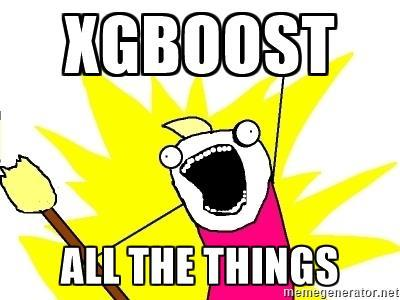

In [126]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

[22:50:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[22:50:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


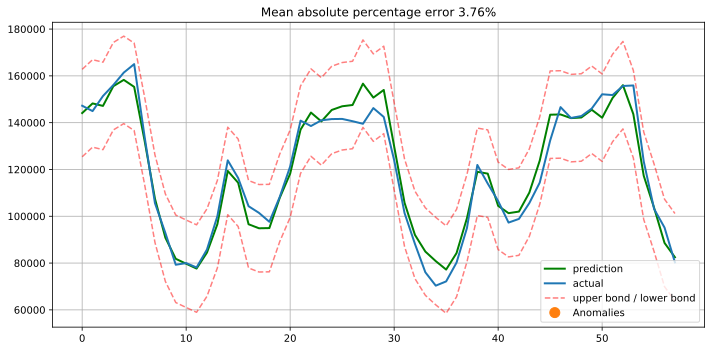

In [127]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

We have a winner! This is the smallest error on the test set among all the models we've tried so far.

But, this victory is decieving, and it might not be the brightest idea to fit xgboost as soon as you get your hands on time series data. Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use XGBoost. For example, you can forecast trend separately with a linear model and then add predictions from xgboost to get a final forecast.

### Conclusion
We discussed different time series analysis and prediction methods. Unfortunately, or maybe luckily, there is no one way to solve these kind of problems. Methods developed in the 1960s (and some even in the beginning of the 21st century) are still popular, along with LSTMs and RNNs (not covered in this article). This is partially related to the fact that the prediction task, like any other data-related task, requires creativity in so many aspects and definitely requires research. In spite of the large number of formal quality metrics and approaches to parameters estimation, it is often necessary to try something different for each time series. Last but not least, the balance between quality and cost is important. As a good example, the SARIMA model can produce spectacular results after tuning but can require many hours of tambourine dancing time series manipulation while a simple linear regression model can be built in 10 minutes and can achieve more or less comparable results.